In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import math
from scipy.interpolate import interp1d

In [34]:
#returns differential atmospheric muon flux
#GeV-1 cm-1 sr-1
def differential_muon_flux(zenith_angle, energy): # angle in radians, energy in GeV
  return 0.14 * (energy ** (-2.7)) * (1 / (1 + ((1.11 * energy * math.cos(zenith_angle)) / 115)) + 0.054 / (1 + (1.11 * energy * math.cos(zenith_angle)) / 850))

In [35]:
#muon flux within the the solid angle of the moon
#assume zenith angle to be 0
def make_diff_muon_flux_through_IceCube_arr(log_energies):
  diff_fluxes = []
  zenith_angle = 0
  muon_solid_angle = 10 ** -3 #considering a wide range around the moon
  for energy in log_energies:
    result = differential_muon_flux(zenith_angle, 10 ** energy) * 10 ** 10
    diff_fluxes.append(result * muon_solid_angle) #we only care about the muons relatively near to the moon
  return diff_fluxes

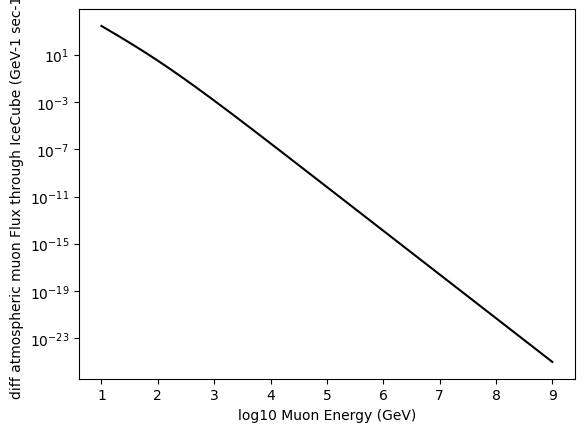

In [36]:
log_muon_energies = np.linspace(1, 9, 1000) # range of muon energies in GeV, linearly spaced

plt.plot(log_muon_energies, make_diff_muon_flux_through_IceCube_arr(log_muon_energies),'k')

plt.xlabel('log10 Muon Energy (GeV)')
plt.ylabel('diff atmospheric muon Flux through IceCube (GeV-1 sec-1)')
plt.yscale('log')

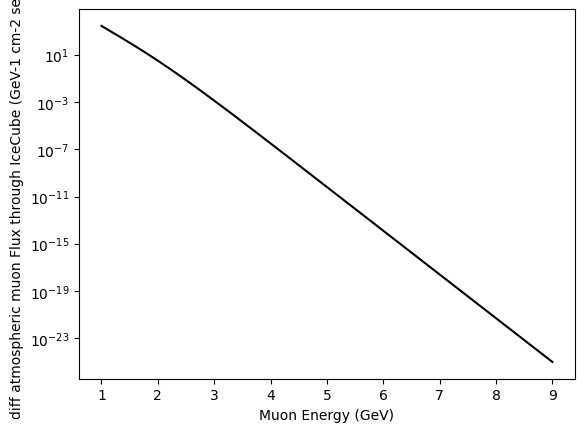

In [37]:
diff_muon_flux_interp = interp1d(log_muon_energies, make_diff_muon_flux_through_IceCube_arr(log_muon_energies),kind='cubic')

plt.plot(log_muon_energies, diff_muon_flux_interp(log_muon_energies),'k')

plt.xlabel('Muon Energy (GeV)')
plt.ylabel('diff atmospheric muon Flux through IceCube (GeV-1 cm-2 sec-1)')
plt.yscale('log')

In [38]:
def diff_muon_flux_with_jacobian(log_energy): #adds jacobian so that we can integrate across log values
  return diff_muon_flux_interp(log_energy) * (10 ** log_energy) * np.log(10)
  
  
def find_muon_flux_range(log_start_energy, log_end_energy): #finds muon flux over a range of energies
  result = quad(diff_muon_flux_interp, log_start_energy, log_end_energy)[0]
  return result
  
  
find_muon_flux_range(5, 8) #around the number of muons we are going to detect


7.51531864633826e-12

In [39]:
# this function finds the energy of a muon travelling a certain distance through the moon
def find_muon_final_energy(E0, distance_through_moon): #energy in GeV, distance in cm
  #constants
  zeta = 2.4 * 10**5 # g / cm^2
  epsilon = 500 #GeV
  moon_density = 3.34 # g / cm^3
  column_depth = distance_through_moon * moon_density

  E_final = ((E0 + epsilon) * np.exp(- column_depth / zeta)) - epsilon
  
  if E_final < 0.1:
    E_final = 0.1

  return E_final

In [40]:
#this is a function so I can see what muons will have enough energy to reach the earth after passing through the moon at different distances
def make_muon_final_energy_array(log_energies, distance):
  final_energies = []
  for energy in log_energies:
    final_energies.append(find_muon_final_energy(10 ** energy, distance))

  return final_energies

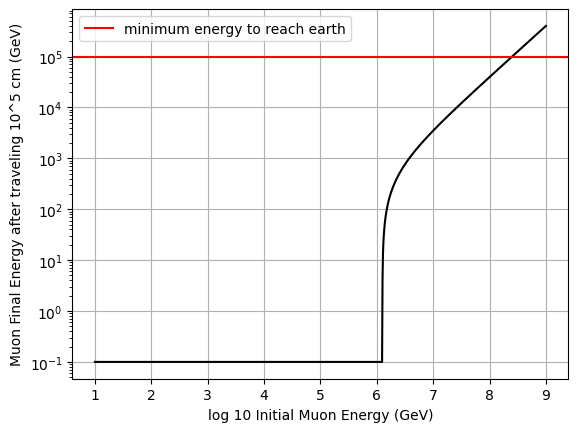

In [60]:
plt.plot(log_muon_energies, make_muon_final_energy_array(log_muon_energies, 10**5.75), 'k')

plt.xlabel('log 10 Initial Muon Energy (GeV)')
plt.ylabel('Muon Final Energy after traveling 10^5 cm (GeV)')
plt.yscale('log')
plt.axhline(y = 10 ** 5, color = 'r', linestyle = '-', label = 'minimum energy to reach earth') 
plt.legend(loc = 'upper left')
plt.grid()

In [42]:
log_neutrino_energies = np.linspace(1, 9, 3000) # range of log10 neutrino energies in GeV, linearly spaced

In [43]:
# returns diffuse astrophysical neutrino flux
def neu_diff_flux(energy): # GeVs
  return 1.8 * (10 ** -18) * (((energy) / (10 ** 5)) ** (-2.52)) # Single power law formula for diffuse neutrino flux
  #/cm^2/s/sr/GeV

In [44]:
def make_neutrino_flux_arr(log_energies):
  fluxes = []
  for energy in log_energies:
    fluxes.append(neu_diff_flux(10 ** energy))
  return fluxes

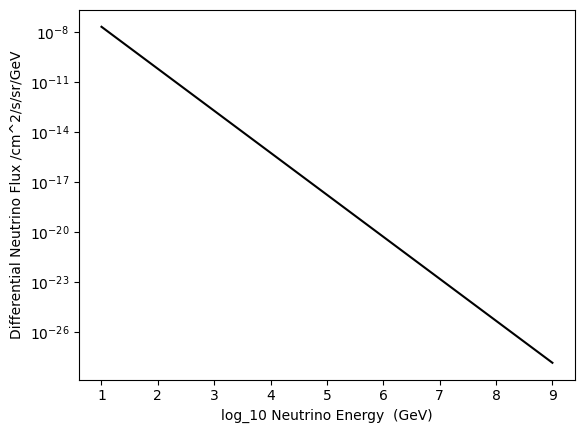

In [45]:
plt.plot(log_neutrino_energies, make_neutrino_flux_arr(log_neutrino_energies),'k')

plt.xlabel('log_10 Neutrino Energy  (GeV)')
plt.ylabel('Differential Neutrino Flux /cm^2/s/sr/GeV')
plt.yscale('log')

In [46]:
#these are values I got from Web Plot Digitizing a CC cross section plot
xs_energies =  [9.98080495607805,
20.998018053876827,
71.59732457299745,
195.63029063568808,
666.9767142701296,
2617.6906006049767,
11125.842153739322,
109783.1765184451,
2562687.509604299,
36940357.82428877,
663344496.668366,
3504806387.090148,
41295060959.3206,
422796003979.0706,
124436989287.35977,
10350845957.459944,
1450095398.5416524,
153442766.75056547,
9634704.158738362,
456524.62382801063]

xs_values = [5.857020818056673e-11, 1.1497569953977356e-10, 3.853528593710535e-10,
             9.770099572992246e-10, 3.1992671377973846e-9, 1.2045035402587812e-8, 4.132012400115343e-8,
             1.9179102616724926e-7, 9.111627561154906e-7, 0.0000030538555088334187, 0.000009111627561154906,
             0.000017073526474706923, 0.00004132012400115343, 0.00009326033468832218,
             0.0000628029144183426,
             0.000025353644939701165,
             0.000012045035402587836,
             0.000005336699231206323,
             0.0000017475284000076865,
             4.3287612810830616e-7]


In [47]:
#returns neutrino-nucleon cross section in mb = 10^-27 cm^2
cc_cross_section = interp1d(xs_energies, xs_values,kind='linear') 

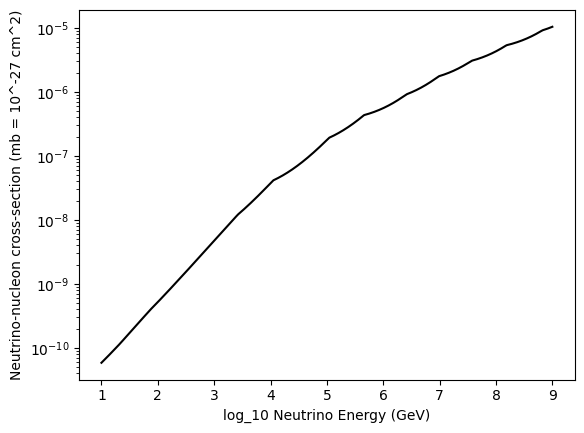

In [48]:
def make_xs_arr(log_energies): #GeV
  cross_sections = []
  for energy in log_neutrino_energies:
    cross_sections.append(cc_cross_section(10 ** energy))
  return cross_sections


plt.plot(log_neutrino_energies, make_xs_arr(log_neutrino_energies),'k')

plt.xlabel('log_10 Neutrino Energy (GeV)')
plt.ylabel('Neutrino-nucleon cross-section (mb = 10^-27 cm^2)')
plt.yscale('log')

In [49]:
#this will try to calculate the rate at which neutrinos will interact with the moon in the sliver I am concerned with
def diff_cc_rate(log_energies):
  # first I need to find the volume of the sliver of the moon that can be used to detect neutrinos, right now I'm modeling it as a thin cylinder
  d_moon = 3.48 * 10 ** 8 # in cm
  L = 10 ** 5 #this is the distance the muons have to travel
  R = d_moon / 2.0
  V_sliver = math.pi * L * (R ** 2 - ((1.0/12) * (L ** 2)))
  print("volume:" + str(V_sliver))

  
  # now I need to find the number of nucleons in the sliver
  density = 3.34 # g / cm^3
  total_mass = V_sliver * density
  nucleon_mass = 1.66 * 10 ** -24
  num_nucleons = total_mass / nucleon_mass
  
  #print("num nucleons is:" + str(num_nucleons))

  diff_rates = []
  
  IceCube_solid_angle = 1.0 / (384400 ** 2) #solid angle = A / R^2
  for energy in log_neutrino_energies:
    diff_nue_flux_thru_moon = neu_diff_flux(10 ** energy) * IceCube_solid_angle
    adjusted_cross_section = cc_cross_section(10 ** energy) * (10 ** -27) #coverts from mb to cm^2
    diff_rates.append(num_nucleons * adjusted_cross_section * diff_nue_flux_thru_moon) # nt * sigma * flux

  return diff_rates

volume:9.511485656209069e+21


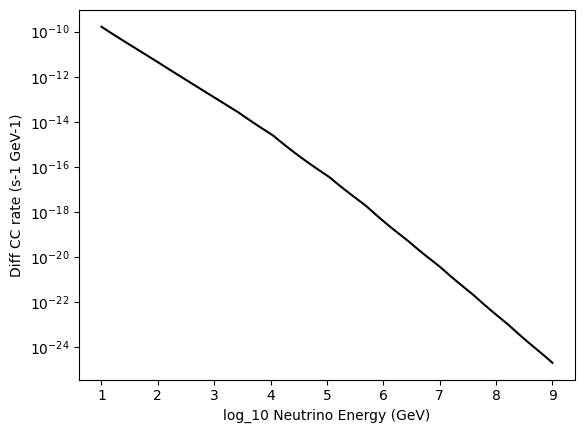

In [50]:
plt.plot(log_neutrino_energies, diff_cc_rate(log_neutrino_energies),'k')

plt.xlabel('log_10 Neutrino Energy (GeV)')
plt.ylabel('Diff CC rate (s-1 GeV-1)')
plt.yscale('log')

volume:9.511485656209069e+21


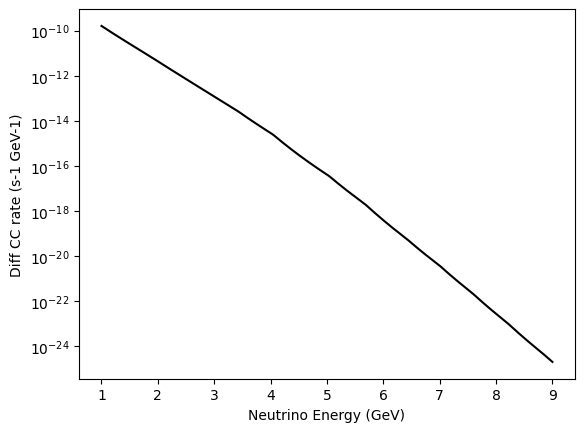

In [51]:
diff_cc_rate_interp = interp1d(log_neutrino_energies, diff_cc_rate(log_neutrino_energies),kind='cubic')

plt.plot(log_neutrino_energies, diff_cc_rate_interp(log_neutrino_energies),'k')

plt.xlabel('Neutrino Energy (GeV)')
plt.ylabel('Diff CC rate (s-1 GeV-1)')
plt.yscale('log')

In [52]:
def cc_rate_with_jacobian(log_energy): #adds jacobian to cc rate function so we can integrate
  return diff_cc_rate_interp(log_energy) * (10 ** log_energy) * np.log(10)

In [53]:
def find_cc_rate_range(start_energy, end_energy):
  result = quad(cc_rate_with_jacobian, start_energy, end_energy, limit=500)[0]
  return result

In [54]:
find_cc_rate_range(5.75, 9) #this is essentially amount of signal muons we will detect per second

6.965002538458796e-13

In [55]:
def make_neutrino_induced_muon_flux_arrs(log_neutrino_energies):
  cc_muon_flux = diff_cc_rate(log_neutrino_energies)
  log_muon_final_energies = []
  
  for i in range(len(log_neutrino_energies)):
    log_muon_final_energy = np.log10(find_muon_final_energy(10 ** log_neutrino_energies[i], 10 ** 5))
    if log_muon_final_energy < 5: #muons need 10^5 GeVs to make it to earth without decaying
      cc_muon_flux[i] = 0
    else:
      cc_muon_flux[i] /= (10 ** 10) #the muon flux we had is spread out over all of IceCube's surface
    log_muon_final_energies.append(log_muon_final_energy)
  
  return log_muon_final_energies, cc_muon_flux

volume:9.511485656209069e+21
volume:9.511485656209069e+21


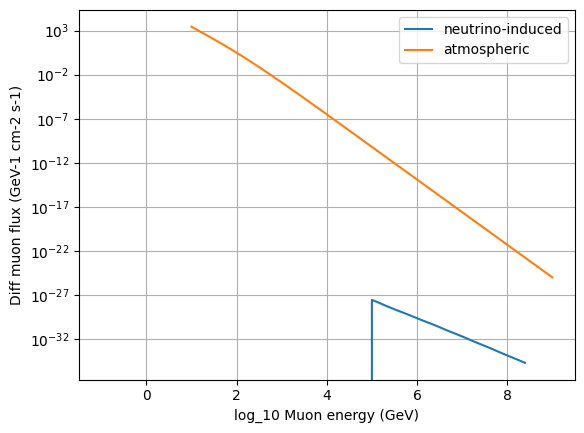

In [56]:
plt.plot(make_neutrino_induced_muon_flux_arrs(log_neutrino_energies)[0], make_neutrino_induced_muon_flux_arrs(log_neutrino_energies)[1], label='neutrino-induced')
plt.plot(log_muon_energies, make_diff_muon_flux_through_IceCube_arr(log_muon_energies), label='atmospheric')


plt.xlabel('log_10 Muon energy (GeV)')
plt.ylabel('Diff muon flux (GeV-1 cm-2 s-1)')
plt.legend(loc='best')
plt.yscale('log')
plt.grid(True)